# Walk-through of data smoothing and hysteresis correction

## Import packages:

In [12]:
import numpy as np
import datetime
import matplotlib.pyplot as plt

## Two needed functions:

In [140]:
# Built for smoothing raw observations in
# preparation for a hysteresis correction in the time dimension.
# Inputs:
#   liUTC: list of datetime objects
#   var: Observations numpy array
#   boxcarWidth: tau or time constant
#   binSize: sampling rate in seconds
def gaussianTime(liUTC, var, boxcarWidth, binSize):
    
    # Make a list that serves as the x coord for the boxcar
    secondsL = [(c - liUTC[0]).total_seconds() for c in liUTC]
        
    # Boxcar width should equal the time constant
    sigma = boxcarWidth / 8
    
    gausAv = []
    for sec, i in zip(secondsL, var):
        boxcarStart = sec - (boxcarWidth/2)
        boxcarEnd = sec + (boxcarWidth/2)
        
        # Make sure the boxcar stays bounded on data edges
        if boxcarStart < 0:
            boxcarStart = 0
        if boxcarEnd > np.nanmax(secondsL):
            boxcarEnd = np.nanmax(secondsL)
        
        binVar = [var[idx] for idx, d in enumerate(secondsL) if boxcarStart <= d <= boxcarEnd]
        binDist = [sec-d for idx, d in enumerate(secondsL) if boxcarStart <= d <= boxcarEnd]
        binDist = np.asarray(binDist)
        
        mu = 0
        weights = (1/(sigma * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((binDist - mu) / sigma) ** 2)
        weightAvg = np.nansum(binVar*weights) / np.nansum(weights[~np.isnan(binVar)])
        
        # Will replace with a nan value if distance to nearest real value is 
        # more than the 2*sampling rate
        if not list(binDist[~np.isnan(binVar)]):
            weightAvg = np.nan
        elif np.nanmin(abs(binDist[~np.isnan(binVar)]))>(2*binSize):
            weightAvg = np.nan
            
        gausAv.append(weightAvg)
    return gausAv

# Function for hysteresis corrections.
# Equation is Var = tau*(dvar/dt)+ var_hat
# var = corrected temp or RH
# tau = time response
# dvar/dt = centered differencing (using previous measurement and next measurement)
# var_hat = actual observed measurement
# t = list of datetime objects
def time_response_correct(var_hat, t, tau):
    var = [np.nan]
    for i in range(1,np.asarray(var_hat).shape[0] - 1):
        t_diff = (t[i+1] - t[i-1]).total_seconds()
        var_new = (tau*((var_hat[i+1]-var_hat[i-1])/(1*t_diff))) + var_hat[i]
        var.append(var_new)

    # Centered difference means index 0/-1 can't be solved for    
    var.append(np.nan)
    var_corr = np.asarray(var)
    return var_corr

## Generate sample data:

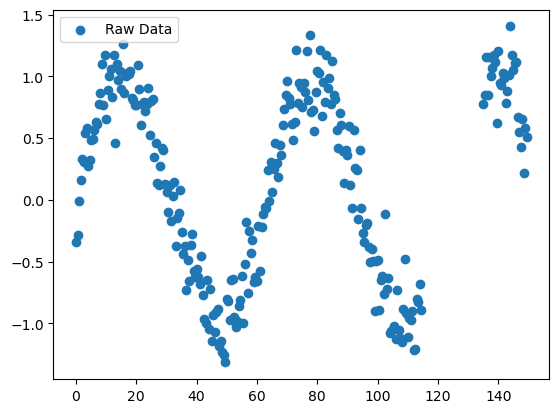

In [98]:
n_samples = 300
sampling_rate = 2 # 2 per second

dto = [datetime.datetime(2025, 9, 4, 22, 0, 0) + datetime.timedelta(seconds=i) for i in np.arange(0, n_samples/sampling_rate, 1/sampling_rate)]
t = [(c - dto[0]).total_seconds() for c in dto]
pure = np.sin(np.multiply(t, 0.1))                  # pure sine
noise = np.random.normal(0, 0.2, n_samples)
y = pure + noise
y[230:270] = np.nan # Insert some nan values
plt.scatter(t, y, label="Raw Data")
plt.legend()
plt.show()

## Example boxcar weights for t=60s:

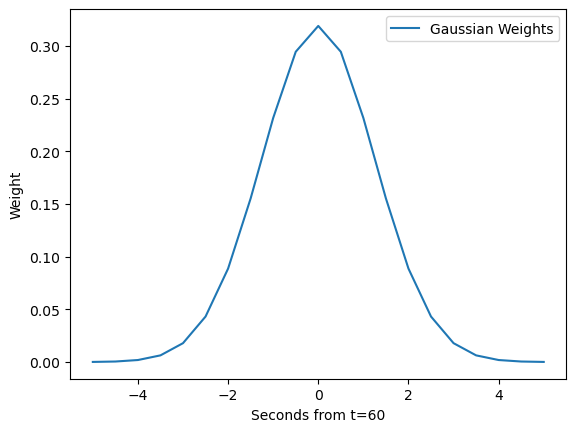

In [134]:
secondsL = t
boxcarWidth = 10 #10 seconds wide
sigma = boxcarWidth / 8
sec = 60
boxcarStart = sec - (boxcarWidth/2)
boxcarEnd = sec + (boxcarWidth/2)
if boxcarStart < 0:
    boxcarStart = 0
if boxcarEnd > np.nanmax(secondsL):
    boxcarEnd = np.nanmax(secondsL)
binDist = [sec-d for idx, d in enumerate(secondsL) if boxcarStart <= d <= boxcarEnd]
binDist = np.asarray(binDist)
mu = 0
weights = (1/(sigma * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((binDist - mu) / sigma) ** 2)

plt.plot(binDist, weights, label="Gaussian Weights")
plt.xlabel(f'Seconds from t={sec}')
plt.ylabel('Weight')
plt.legend()
plt.show()

## Apply smoothing to the data

C:\Users\mdebruin2\AppData\Local\Temp\ipykernel_5184\1808182911.py:35: RuntimeWarning: invalid value encountered in scalar divide
  weightAvg = np.nansum(binVar*weights) / np.nansum(weights[~np.isnan(binVar)])


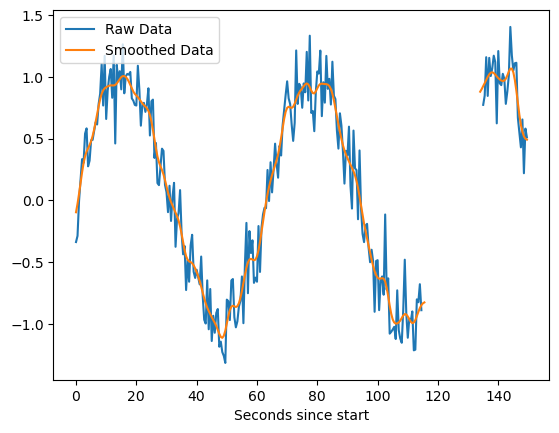

In [138]:
tau = 10
y_smooth = gaussianTime(dto, y, tau, 1/sampling_rate)
plt.plot(t, y, label="Raw Data")
plt.plot(t, y_smooth, label="Smoothed Data")
plt.xlabel('Seconds since start')
plt.legend()
plt.show()

## Apply a hysteresis correction

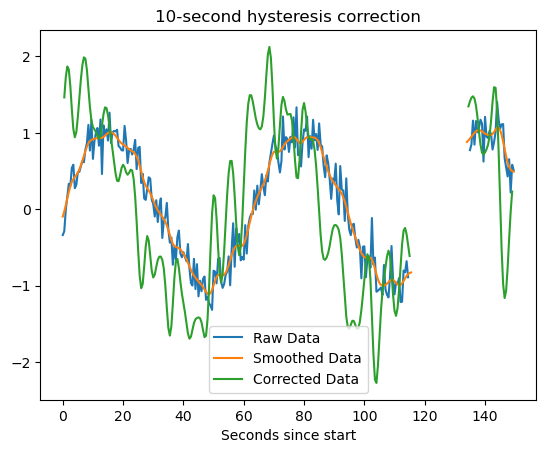

In [139]:
y_corr = time_response_correct(y_smooth, dto, tau)
plt.plot(t, y, label="Raw Data")
plt.plot(t, y_smooth, label="Smoothed Data")
plt.plot(t, y_corr, label="Corrected Data")
plt.xlabel('Seconds since start')
plt.legend()
plt.title(f'{tau}-second hysteresis correction')
plt.show()

## Why smooth first?

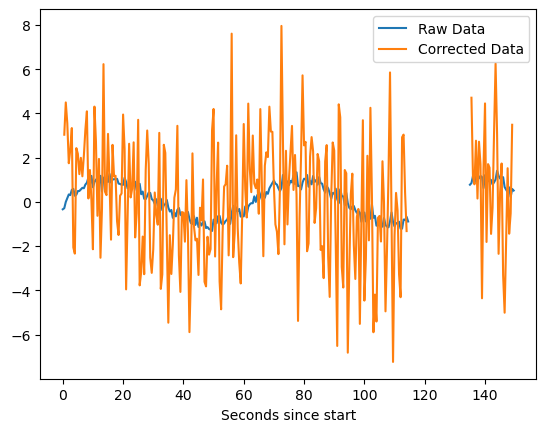

In [132]:
# Hysteresis correct raw data
y_corr = time_response_correct(y, dto, tau)
plt.plot(t, y, label="Raw Data")
plt.plot(t, y_corr, label="Corrected Data")
plt.xlabel('Seconds since start')
plt.legend()
plt.show()